In [1]:
%matplotlib inline
import sys
from datetime import datetime as dt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor

sys.path.append('../')
from util.feature import add_feature, fillna
from util.metric import mse
from util import variables

sns.set(style='white')
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [2]:
train_data = pd.read_csv('../data/d_train_20180102.csv')
test_data = pd.read_csv('../data/d_test_A_20180102.csv')
test_data['血糖'] = -1
data = pd.concat([train_data, test_data], ignore_index=True)
data = fillna(data)
data = add_feature(data)

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['性别']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


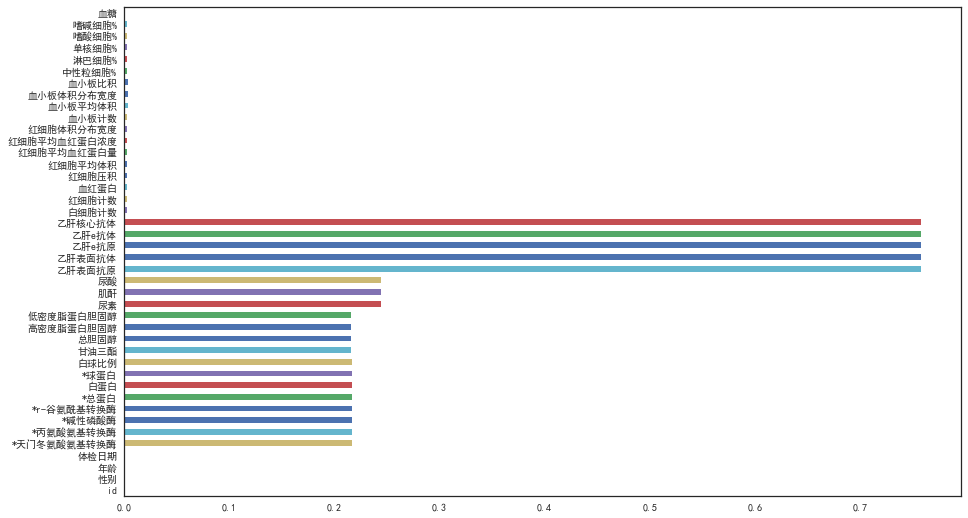

In [3]:
na_data = train_data.isna().sum() / train_data.shape[0]
fig_na, ax_na = plt.subplots(figsize=(15,9))
na_data.plot.barh(ax=ax_na)

In [17]:
train_data.describe().to_csv('../data/descibe.csv')

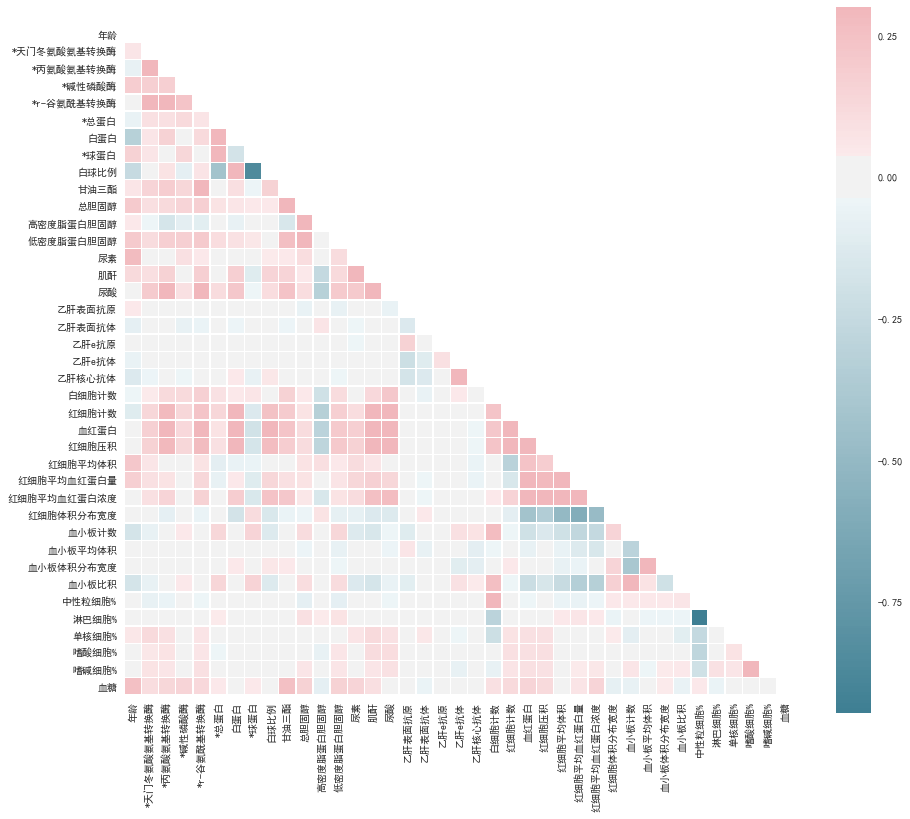

In [5]:
corr = train_data.loc[:, '年龄':].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig_corr, ax_corr = plt.subplots(figsize=(15, 13))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidth=.5, ax=ax_corr)

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
D:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(-50, 810)

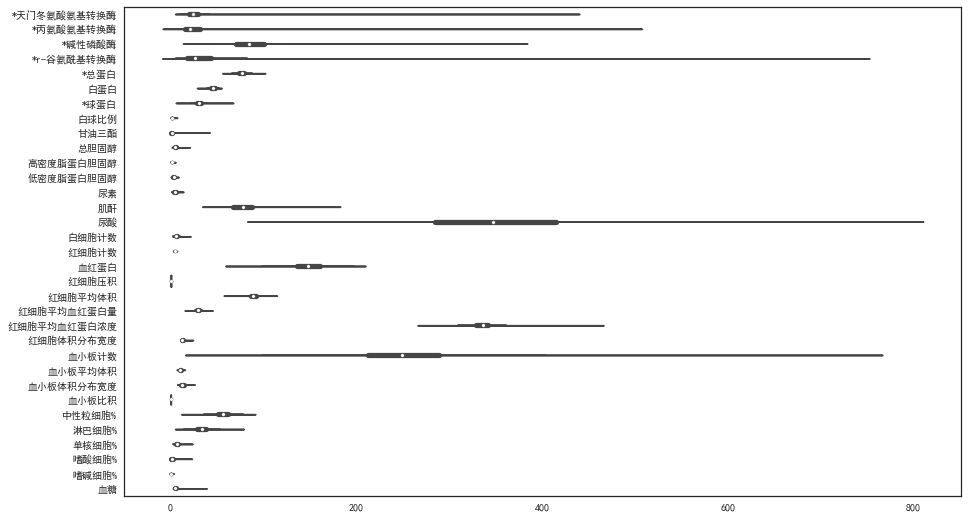

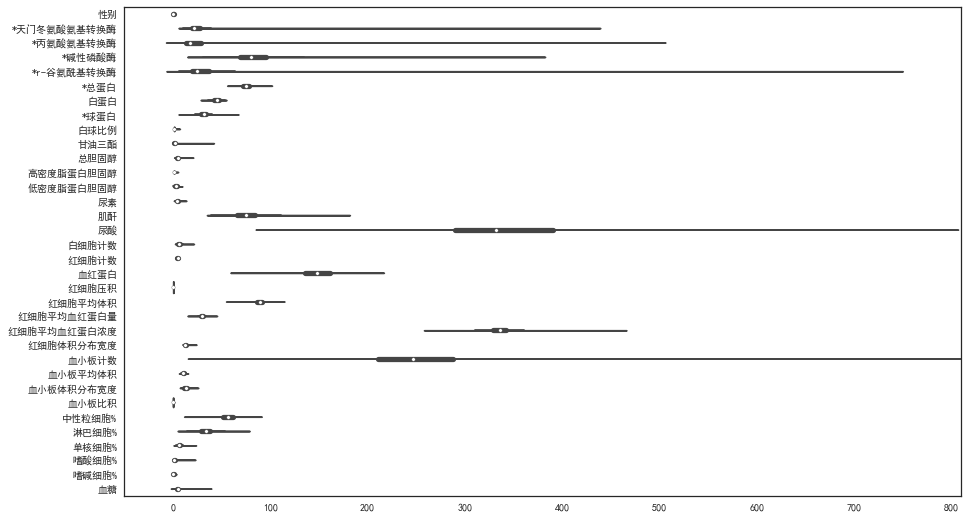

In [6]:
fig_boxt, ax_boxt = plt.subplots(figsize=(15, 9))
XTrain = train_data.loc[:, [column for column in train_data.columns if column not in 
                        ['id', '年龄', '体检日期', '乙肝表面抗原',
                         '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体',
                         'dayofyear']]]
sns.violinplot(data=XTrain, orient="h", ax=ax_boxt)

fig_boxa, ax_boxa = plt.subplots(figsize=(15, 9))
XALL = data.loc[:, [column for column in train_data.columns if column not in 
                    ['id', '年龄', '体检日期', '乙肝表面抗原',
                     '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体',
                     'dayofyear']]]
sns.violinplot(data=XALL, orient="h", ax=ax_boxa)
ax_boxa.set_xlim(left=-50, right=810)

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
D:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


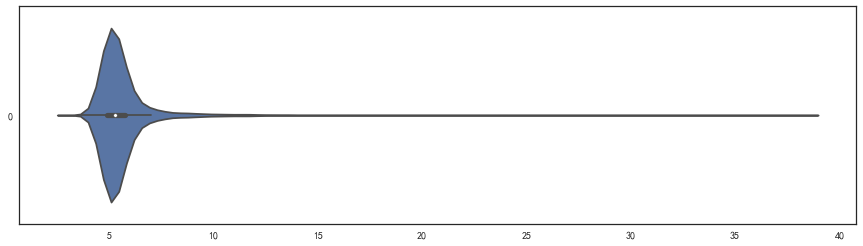

In [7]:
fig_gluvalue, ax_gluvalue = plt.subplots(figsize=(15, 4))
sns.violinplot(data=train_data['血糖'], orient="h", ax=ax_gluvalue)

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


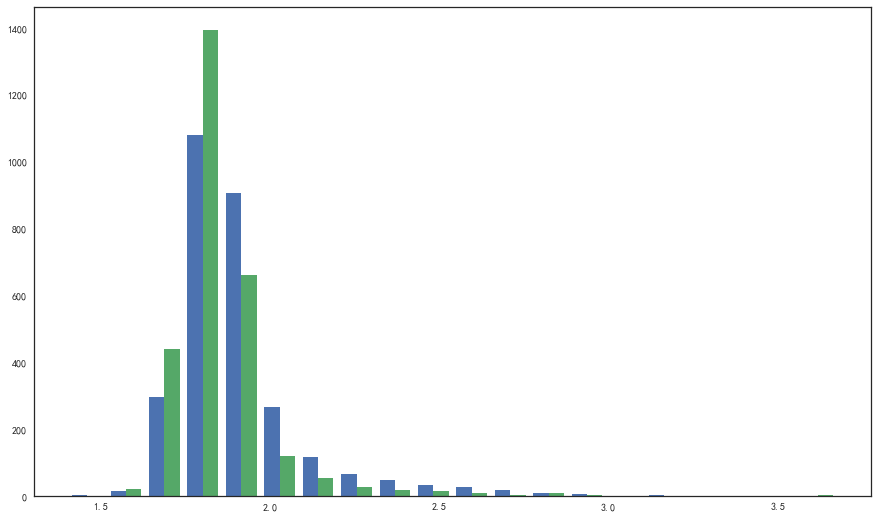

In [8]:
from scipy.special import boxcox1p
fig_gluhist, ax_gluhist = plt.subplots(figsize=(15, 9))
n, bins, pathes = ax_gluhist.hist([np.log1p(train_data.loc[train_data['性别'] == '男', '血糖']), 
                                   np.log1p(train_data.loc[train_data['性别'] == '女', '血糖'])],
                                   bins=20)

33


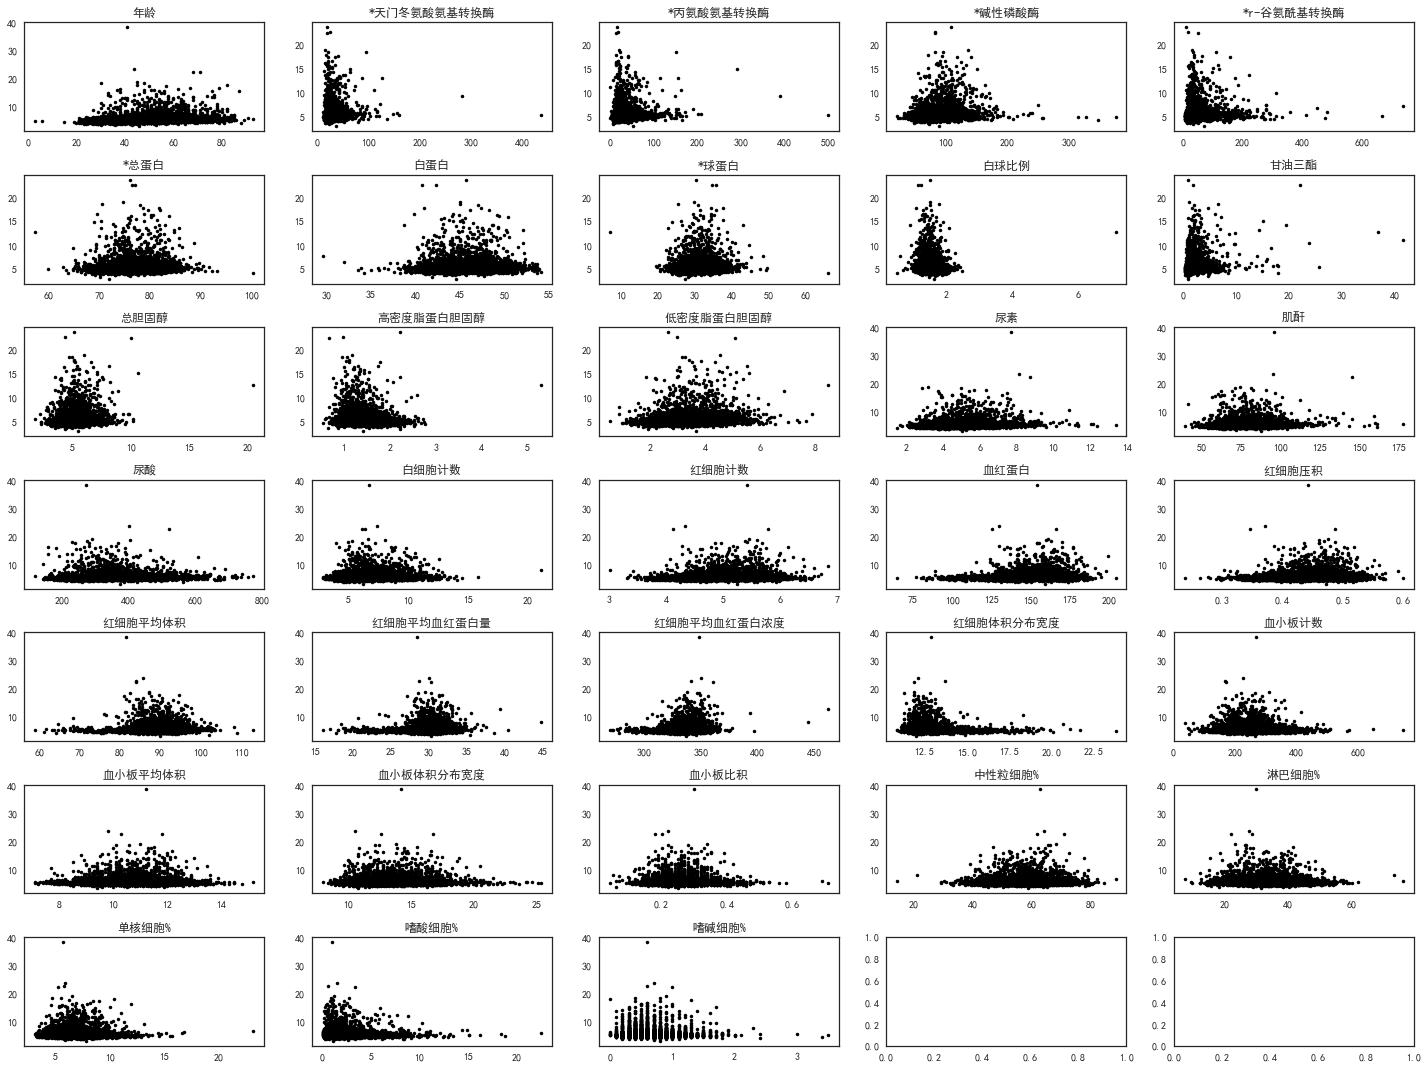

In [9]:
origin_feature = [column for column in train_data.columns if column not in ['id', '性别', '血糖', '体检日期', '乙肝表面抗原',
                         '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体']]
print(len(origin_feature))
fig_f2o, ax_f2o = plt.subplots(7, 5, figsize=(20, 15))
for idx, col in enumerate(origin_feature):
    ax_f2o[idx//5, idx%5].plot(train_data[col], train_data['血糖'], 'k.')
    ax_f2o[idx//5, idx%5].set_title(col)
fig_f2o.tight_layout()

In [10]:
train = fillna(train_data)
train = add_feature(train)

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['性别']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


In [11]:
XALL = train.loc[:, [column for column in train.columns if column not in ['id', '体检日期', '血糖', '性别']]]
yALL = train.loc[:, '血糖']
feature_col = XALL.columns
scaler = StandardScaler()
XALL = scaler.fit_transform(XALL)
XALL = pd.DataFrame(XALL, columns=feature_col)

all_set = lgb.Dataset(XALL, label=yALL)
gbm = lgb.train(variables.lgb_params, all_set,
                num_boost_round=10000,
                early_stopping_rounds=variables.early_stopping_rounds,
                valid_sets=[all_set],
                verbose_eval=100,
                feval=mse)
glu = gbm.predict(XALL)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.99063	training's mse: 0.995376
[200]	training's l2: 1.79164	training's mse: 0.895838
[300]	training's l2: 1.64395	training's mse: 0.821963
[400]	training's l2: 1.51506	training's mse: 0.757528
[500]	training's l2: 1.40775	training's mse: 0.703827
[600]	training's l2: 1.31007	training's mse: 0.655109
[700]	training's l2: 1.2239	training's mse: 0.612008
[800]	training's l2: 1.1399	training's mse: 0.56992
[900]	training's l2: 1.06784	training's mse: 0.533961
[1000]	training's l2: 1.00084	training's mse: 0.50042
[1100]	training's l2: 0.938276	training's mse: 0.469142
[1200]	training's l2: 0.881914	training's mse: 0.440977
[1300]	training's l2: 0.830146	training's mse: 0.415043
[1400]	training's l2: 0.783022	training's mse: 0.391532
[1500]	training's l2: 0.737537	training's mse: 0.368814
[1600]	training's l2: 0.699345	training's mse: 0.349701
[1700]	training's l2: 0.662351	training's mse: 0.331142
[1800]	t

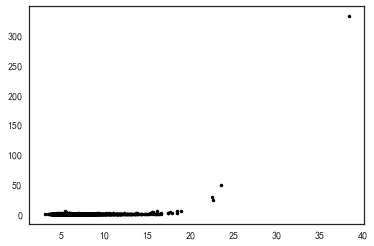

In [12]:
mse_loss = (glu - yALL)**2
fig_loss, ax_loss = plt.subplots()
ax_loss.plot(yALL, mse_loss, 'k.', lw=0.1)

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Features'),
 Text(0.5,0,'VIF Scores'),
 Text(0.5,1,'Variables Which Exhibit Multicollinearity')]

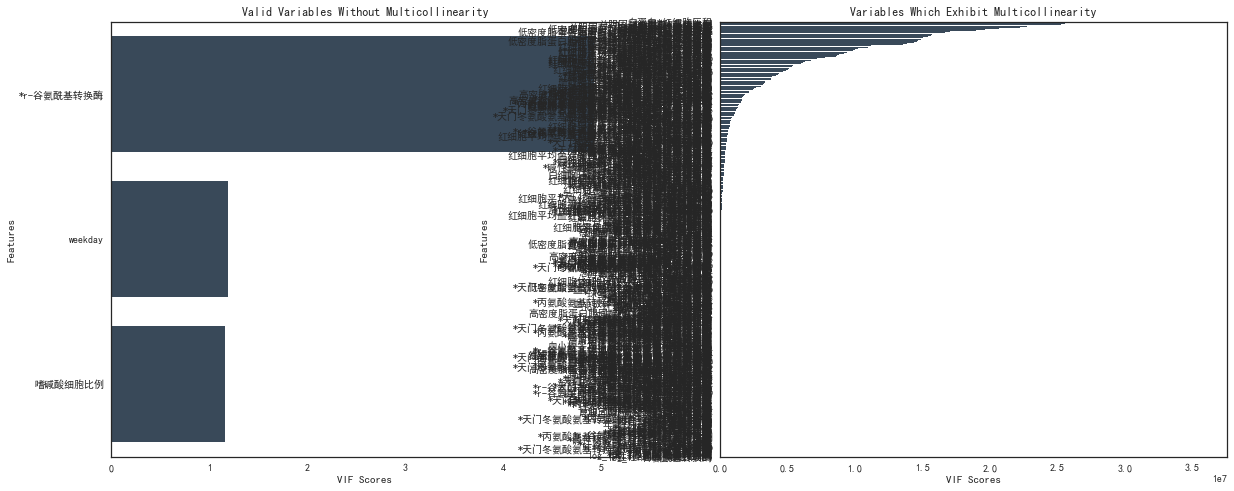

In [13]:
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

vif_dict = calculate_vif_(XALL)

vif_df = pd.DataFrame()
vif_df['variables'] = vif_dict.keys()
vif_df['vif_score'] = vif_dict.values()
vif_df.sort_values(by=['vif_score'], ascending=False, inplace=True)
valid_var = vif_df[vif_df['vif_score'] <= 5]
var_with_MC = vif_df[vif_df['vif_score'] > 5]

fig_collinear,ax_collinear = plt.subplots(ncols=2)
fig_collinear.set_size_inches(20,8)
sns.barplot(data=valid_var,x="vif_score",y="variables",ax=ax_collinear[0],orient="h",color="#34495e")
sns.barplot(data=var_with_MC,x="vif_score",y="variables",ax=ax_collinear[1],orient="h",color="#34495e")
ax_collinear[0].set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax_collinear[1].set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")